<a href="https://colab.research.google.com/github/waleedharoonnnn/TumorNet-Classifier-Segmenter/blob/main/train_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TumorNet-Classifier-Segmenter: Model Training
Created by: waleed haroon

This notebook demonstrates the training of two deep learning models for brain tumor analysis using MRI images:

1.  **CNN (Convolutional Neural Network) Classifier:** This model is trained to classify whether an MRI image contains a brain tumor or not.
2.  **U-Net Segmenter:** This model is trained to segment the tumor region within an MRI image if a tumor is present.

## Dataset

The datasets used in this notebook are from Kaggle:

*   **Classification Dataset:** "Brain MRI Images for Brain Tumor Detection" by Navoneel (used for training the CNN classifier). This dataset contains images categorized as 'yes' (tumor) and 'no' (no tumor). We used **253 images** from this dataset.
*   **Segmentation Dataset:** "LGG MRI Segmentation" by Mateusz Buda et al. (used for training the U-Net segmenter). This dataset provides MRI images and corresponding masks highlighting the tumor region. We used **500 images** from this dataset for training.

## How it Works

The project follows these steps:

1.  **Data Loading and Preparation:** MRI images for both classification (tumor/no tumor) and segmentation (image/mask) are loaded and preprocessed (resized and normalized).
2.  **CNN Training:** A CNN model is built and trained on the classification dataset to learn features that distinguish between images with and without tumors.
3.  **U-Net Training:** A U-Net model is built and trained on the segmentation dataset to learn to predict a mask that highlights the tumor area in the image.
4.  **Inference:** An uploaded MRI image is first passed through the trained CNN to determine if a tumor is likely present. If a tumor is detected, the image is then passed through the trained U-Net to generate a segmentation mask, which is then overlaid on the original image to visualize the tumor location.

## Training Details

*   **CNN Classifier Training:** The CNN model is trained using the Adam optimizer and binary crossentropy loss. It is trained for 10 epochs with a validation split of 20% to monitor performance on unseen data during training.
*   **U-Net Segmenter Training:** The U-Net model is trained using the Adam optimizer and binary crossentropy loss. It is trained for 3 epochs with a validation split of 20%.

## Model Architectures

*   **CNN for Classification:** CNNs are well-suited for image classification tasks. They use convolutional layers to automatically learn hierarchical features from the input images. Pooling layers reduce spatial dimensions, and fully connected layers make the final prediction (tumor or no tumor).
*   **U-Net for Segmentation:** U-Net is a specialized architecture for image segmentation. It has an encoder-decoder structure with skip connections. The encoder captures context (like a CNN), while the decoder upsamples the feature maps to produce a pixel-wise segmentation mask. The skip connections help the decoder recover fine-grained details lost during downsampling.

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)


TensorFlow version: 2.18.0
Keras version: 3.8.0


In [ ]:
# For Colab only
!pip install kaggle opencv-python matplotlib scikit-learn tensorflow


In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json here

# Move to ~/.kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection
# Delete old folder first (optional)
!rm -rf data/brain_tumor_dataset

# Then unzip
!unzip -o brain-mri-images-for-brain-tumor-detection.zip -d data/



Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
  0% 0.00/15.1M [00:00<?, ?B/s]
100% 15.1M/15.1M [00:00<00:00, 979MB/s]
Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: data/brain_tumor_dataset/no/1 no.jpeg  
  inflating: data/brain_tumor_dataset/no/10 no.jpg  
  inflating: data/brain_tumor_dataset/no/11 no.jpg  
  inflating: data/brain_tumor_dataset/no/12 no.jpg  
  inflating: data/brain_tumor_dataset/no/13 no.jpg  
  inflating: data/brain_tumor_dataset/no/14 no.jpg  
  inflating: data/brain_tumor_dataset/no/15 no.jpg  
  inflating: data/brain_tumor_dataset/no/17 no.jpg  
  inflating: data/brain_tumor_dataset/no/18 no.jpg  
  inflating: data/brain_tumor_dataset/no/19 no.jpg  
  inflating: data/brain_tumor_dataset/no/2 no.jpeg  
  inflating: data/brain_tumor_dataset/no/20 no.jpg  
  inflating: data/brain_tumor_dataset/no/21 no.jpg  
  inflating: data/brain_tumor_dataset/no/22 no.jpg  
  

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def load_classification_data(yes_dir, no_dir, img_size=(224, 224)):
    X, y = [], []

    for filename in os.listdir(yes_dir):
        img = cv2.imread(os.path.join(yes_dir, filename))
        if img is not None:
            img = cv2.resize(img, img_size)
            X.append(img)
            y.append(1)

    for filename in os.listdir(no_dir):
        img = cv2.imread(os.path.join(no_dir, filename))
        if img is not None:
            img = cv2.resize(img, img_size)
            X.append(img)
            y.append(0)

    return np.array(X) / 255.0, np.array(y)

# Load and split
X_class, y_class = load_classification_data('data/brain_tumor_dataset/yes', 'data/brain_tumor_dataset/no')
X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def build_classifier(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),

        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

classifier = build_classifier(X_class.shape[1:])
classifier.fit(X_class, y_class, epochs=10, validation_split=0.2)

# Recommended for Keras 3
classifier.save("classifier_model.keras")



Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.6519 - loss: 0.9861 - val_accuracy: 0.0196 - val_loss: 1.6444
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.7911 - loss: 0.7222 - val_accuracy: 0.3922 - val_loss: 1.2925
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.8417 - loss: 0.6221 - val_accuracy: 0.3137 - val_loss: 1.4452
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.8923 - loss: 0.6388 - val_accuracy: 0.3725 - val_loss: 1.3247
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8603 - loss: 0.5791 - val_accuracy: 0.3725 - val_loss: 1.2845
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.8655 - loss: 0.5669 - val_accuracy: 0.3529 - val_loss: 1.4444
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8661 - loss: 0.5573 - val_accuracy: 0.4510 - val_loss: 1.2760
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8437 - loss: 0.5594 - val_accuracy: 0.3529 - val_loss: 1.4536
Epoch 9/

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=classifier_model.

In [ ]:
a

In [40]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
!unzip lgg-mri-segmentation.zip -d seg_data/


Streaming output truncated to the last 5000 lines.
  inflating: seg_data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: seg_data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: seg_data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: seg_data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: seg_data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: seg_data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: seg_data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: seg_data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: seg_data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_

In [31]:
def load_segmentation_data(base_path, img_size=(128, 128), max_samples=500):
    images = []
    masks = []
    sample_count = 0

    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        if not os.path.isdir(folder_path):
            continue

        all_files = os.listdir(folder_path)
        image_files = [f for f in all_files if '_mask' not in f.lower()]
        mask_files = [f for f in all_files if '_mask' in f.lower()]

        # Sort to pair correctly
        image_files.sort()
        mask_files.sort()

        for img_file, mask_file in zip(image_files, mask_files):
            img_path = os.path.join(folder_path, img_file)
            mask_path = os.path.join(folder_path, mask_file)

            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if img is None or mask is None:
                continue

            img = cv2.resize(img, img_size)
            mask = cv2.resize(mask, img_size)

            images.append(img)
            masks.append(mask)
            sample_count += 1

            if sample_count >= max_samples:
                break
        if sample_count >= max_samples:
            break

    # Normalize
    images = np.array(images) / 255.0
    masks = (np.array(masks) > 127).astype(np.float32)
    masks = np.expand_dims(masks, axis=-1)

    return images, masks


In [32]:
X_seg, y_seg = load_segmentation_data('/content/seg_data/lgg-mri-segmentation/kaggle_3m', max_samples=500)
print(f"✅ Loaded {len(X_seg)} images and {len(y_seg)} masks")

model = unet_model()
model.compile(optimizer=Adam(1e-4), loss=BinaryCrossentropy(), metrics=['accuracy'])
model.fit(X_seg, y_seg, validation_split=0.2, epochs=3, batch_size=8)

model.save('segmenter.h5')


✅ Loaded 500 images and 500 masks
Epoch 1/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 588s 11s/step - accuracy: 0.9070 - loss: 0.3976 - val_accuracy: 0.9906 - val_loss: 0.0473
Epoch 2/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 615s 11s/step - accuracy: 0.9892 - loss: 0.0513 - val_accuracy: 0.9906 - val_loss: 0.0403
Epoch 3/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 560s 11s/step - accuracy: 0.9913 - loss: 0.0406 - val_accuracy: 0.9906 - val_loss: 0.0409


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Tumor probability: 1.000 → Tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


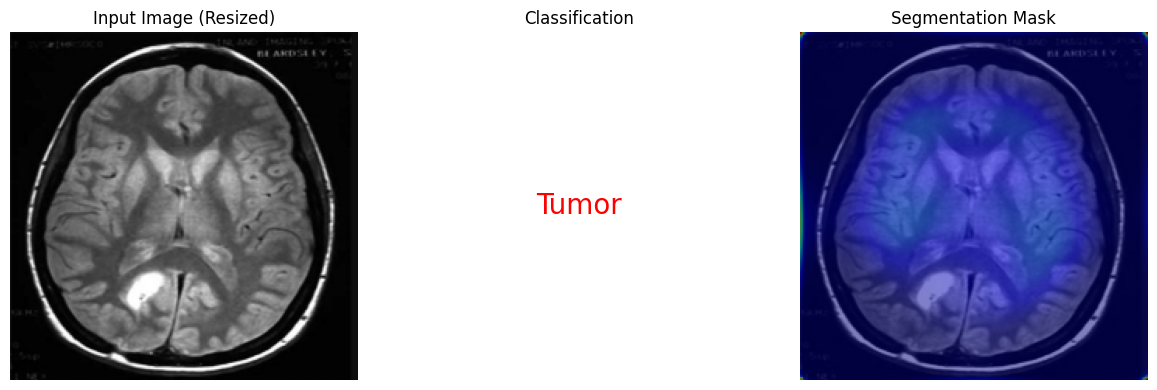

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Replace 'my_mri.jpg' with your uploaded file name
uploaded_filename = list(uploaded.keys())[0]  # get uploaded file name dynamically

# Load original image (BGR format)
img_bgr = cv2.imread(uploaded_filename)
if img_bgr is None:
    raise ValueError("Image not loaded. Check filename and upload.")

# Convert BGR to RGB
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Resize for classifier (224x224)
img_classifier = cv2.resize(img_rgb, (224, 224)) / 255.0
img_classifier_input = np.expand_dims(img_classifier, axis=0)

# Resize for segmenter (128x128)
img_segmenter = cv2.resize(img_rgb, (128, 128)) / 255.0
img_segmenter_input = np.expand_dims(img_segmenter, axis=0)

# Predict with classifier
pred_prob = classifier.predict(img_classifier_input)[0][0]
label = 'Tumor' if pred_prob > 0.5 else 'No Tumor'
print(f"Tumor probability: {pred_prob:.3f} → {label}")

# Predict with segmenter
mask_pred = segmenter.predict(img_segmenter_input)[0]  # (128,128,1)

# Resize mask to classifier size for overlay (224x224)
mask_resized = cv2.resize(mask_pred.squeeze(), (224, 224))

# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_classifier)
plt.title('Input Image (Resized)')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.text(0.5, 0.5, label,
         fontsize=20, ha='center', va='center',
         color='red' if pred_prob > 0.5 else 'green')
plt.title('Classification')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_classifier)
plt.imshow(mask_resized, cmap='jet', alpha=0.5)
plt.title('Segmentation Mask')
plt.axis('off')

plt.tight_layout()
plt.show()
